In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from attr.filters import exclude

In [3]:
df = pd.read_parquet("../data/data_with_meteo.parquet")

df.head()

,stationcode,name,is_installed,capacity,numdocksavailable,numbikesavailable,mechanical,ebike,is_renting,is_returning,duedate,coordonnees_geo,nom_arrondissement_communes,code_insee_commune,temperature_2m,precipitation,rain,snowfall,relative_humidity_2m
0,16107,Benjamin Godard - Victor Hugo,OUI,35.0,30,5,2,3,OUI,OUI,2024-10-21 12:49:53+00:00,"[48.865983, 2.275725]",Paris,75056,20.75,0.0,0.0,0.0,71.68051
1,9020,Toudouze - Clauzel,OUI,21.0,18,2,0,2,OUI,OUI,2024-10-21 12:46:01+00:00,"[48.87929591733507, 2.3373600840568547]",Paris,75056,20.75,0.0,0.0,0.0,71.68051
2,14111,Cassini - Denfert-Rochereau,OUI,25.0,21,1,1,0,OUI,OUI,2024-10-21 12:47:41+00:00,"[48.837525839067, 2.3360354080796]",Paris,75056,20.75,0.0,0.0,0.0,71.68051
3,13007,Le Brun - Gobelins,OUI,48.0,40,4,1,3,OUI,OUI,2024-10-21 12:49:56+00:00,"[48.835092787824, 2.3534681351338]",Paris,75056,20.75,0.0,0.0,0.0,71.68051
4,5110,Lacépède - Monge,OUI,23.0,6,17,7,10,OUI,OUI,2024-10-21 12:48:48+00:00,"[48.84389286531899, 2.3519663885235786]",Paris,75056,20.75,0.0,0.0,0.0,71.68051


In [100]:
df.shape

(182166, 19)

In [101]:
df.dtypes

stationcode                                 object
name                                        object
is_installed                                object
capacity                                   float64
numdocksavailable                            int64
numbikesavailable                            int64
mechanical                                   int64
ebike                                        int64
is_renting                                  object
is_returning                                object
duedate                        datetime64[ns, UTC]
coordonnees_geo                             object
nom_arrondissement_communes                 object
code_insee_commune                          object
temperature_2m                             float64
precipitation                              float64
rain                                       float64
snowfall                                   float64
relative_humidity_2m                       float64
dtype: object

In [102]:
df.isna().sum().sort_values(ascending=False)

name                           1
code_insee_commune             1
capacity                       1
nom_arrondissement_communes    1
coordonnees_geo                1
is_installed                   0
stationcode                    0
ebike                          0
numdocksavailable              0
numbikesavailable              0
mechanical                     0
duedate                        0
is_returning                   0
is_renting                     0
temperature_2m                 0
precipitation                  0
rain                           0
snowfall                       0
relative_humidity_2m           0
dtype: int64

In [103]:
targets = df[['numbikesavailable', 'numdocksavailable']]

targets.head(100)

,numbikesavailable,numdocksavailable
0,5,30
1,2,18
2,1,21
3,4,40
4,17,6
...,...,...
95,28,37
96,7,27
97,7,26
98,25,2


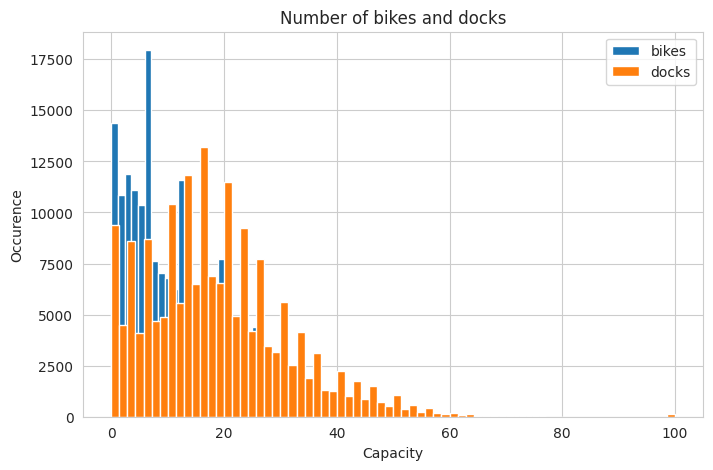

In [104]:
bikes = targets['numbikesavailable']
docks = targets['numdocksavailable']

plt.figure(figsize=(8, 5))
plt.hist(bikes, bins=70, label="bikes")
plt.hist(docks, bins=70, label="docks")
plt.title("Number of bikes and docks")
plt.ylabel("Occurence")
plt.xlabel("Capacity")
plt.legend()
plt.legend()

In [105]:
df.drop(columns=['stationcode', 'nom_arrondissement_communes', 'code_insee_commune'], inplace=True)

split = df['coordonnees_geo'].astype(str).str.strip('[]').str.split(" ", expand=True)
split

,0,1,2,3,4,5
0,48.865983,,2.275725,None,None,None
1,48.87929592,,2.33736008,None,None,None
2,48.83752584,,2.33603541,None,None,None
3,48.83509279,,2.35346814,None,None,None
4,48.84389287,,2.35196639,None,None,None
...,...,...,...,...,...,...
182161,48.88879656,,2.39258119,None,None,None
182162,48.88360109,,2.33322378,None,None,None
182163,48.8714991,,,2.31389617,None,None
182164,48.84179501,,2.37678502,None,None,None


In [106]:
df['lat'] = split[0]
df['lon'] = split[2]

df.drop(columns=['coordonnees_geo'], inplace=True)

In [107]:
df['duedate'] = pd.to_datetime(df['duedate'])
df['hour'] = df['duedate'].dt.hour
df['dayofweek'] = df['duedate'].dt.dayofweek  # 0=lundi
df['is_weekend'] = df['dayofweek'] >= 5


In [108]:
cat_values = df.select_dtypes(['object'])
cat_values.columns

Index(['name', 'is_installed', 'is_renting', 'is_returning', 'lat', 'lon'], dtype='object')

Text(0.5, 1.0, 'Correlation')

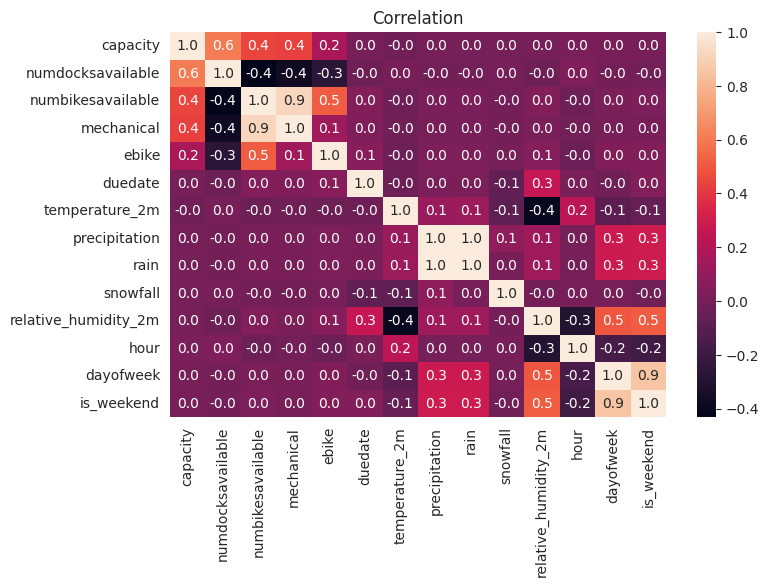

In [109]:
num_values = df.drop(columns=cat_values.columns)
corr = num_values.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt=".1f")
plt.title("Correlation")

/tmp/ipykernel_40106/2525257216.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 2))


<Figure size 500x200 with 0 Axes>

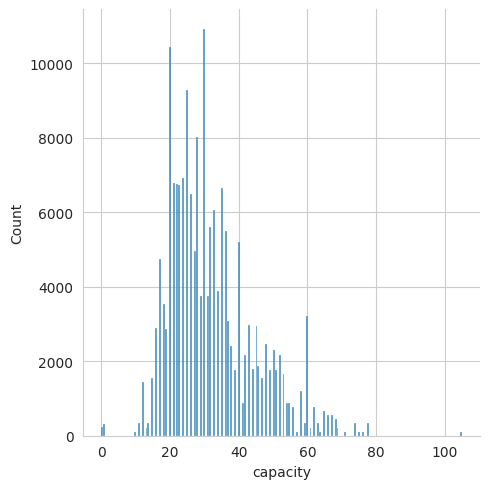

<Figure size 500x200 with 0 Axes>

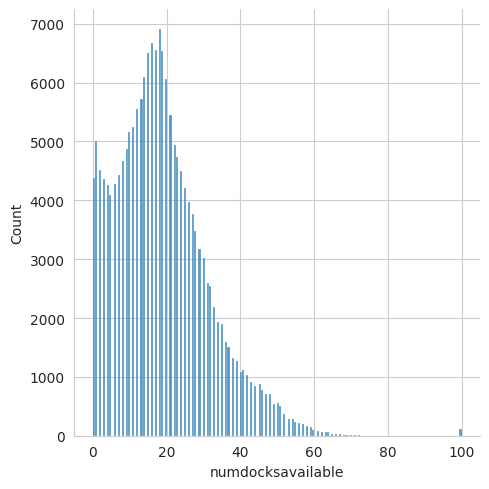

<Figure size 500x200 with 0 Axes>

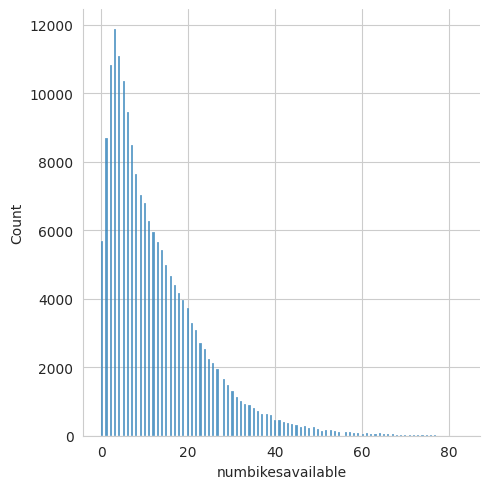

<Figure size 500x200 with 0 Axes>

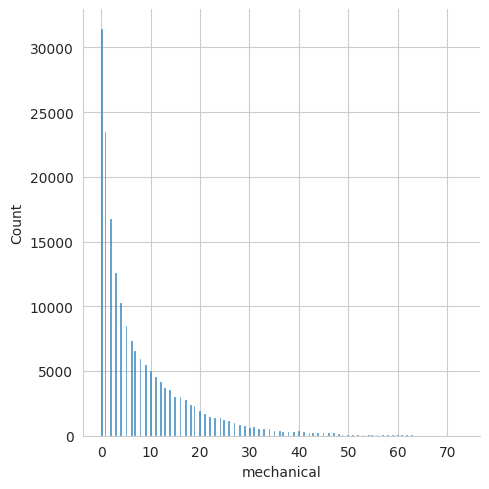

<Figure size 500x200 with 0 Axes>

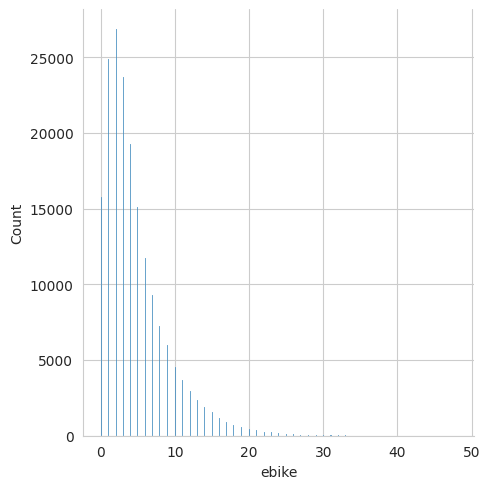

<Figure size 500x200 with 0 Axes>

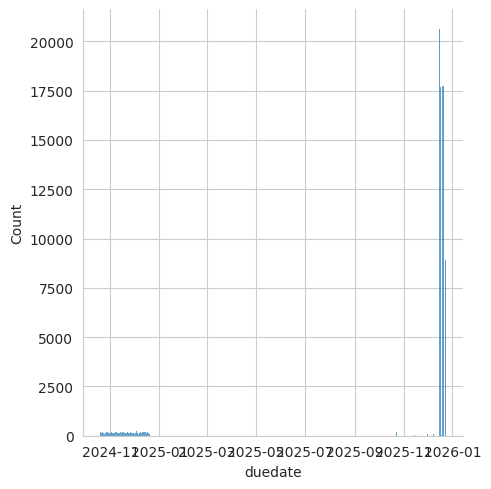

<Figure size 500x200 with 0 Axes>

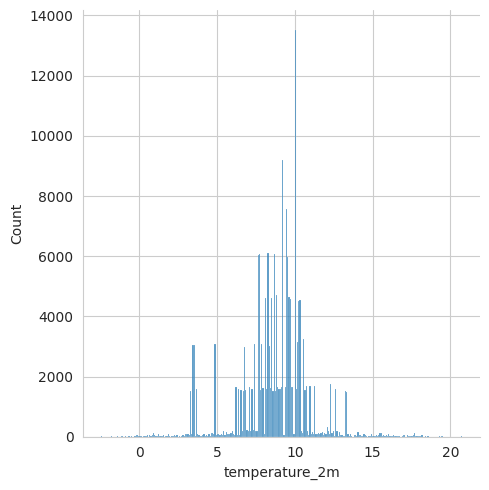

<Figure size 500x200 with 0 Axes>

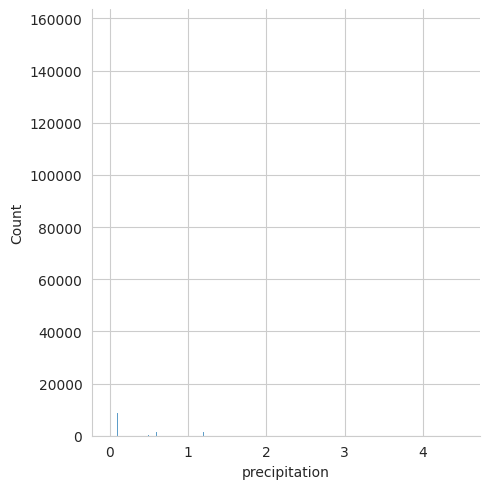

<Figure size 500x200 with 0 Axes>

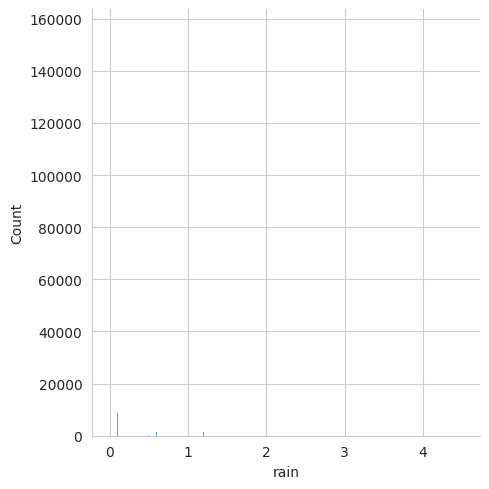

<Figure size 500x200 with 0 Axes>

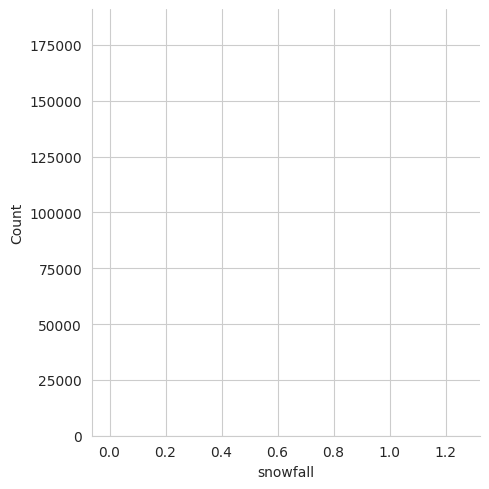

<Figure size 500x200 with 0 Axes>

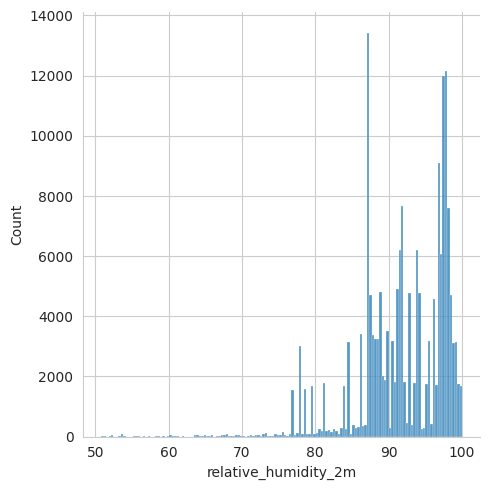

<Figure size 500x200 with 0 Axes>

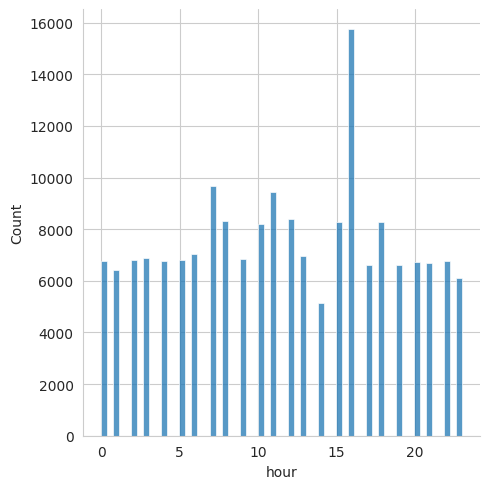

<Figure size 500x200 with 0 Axes>

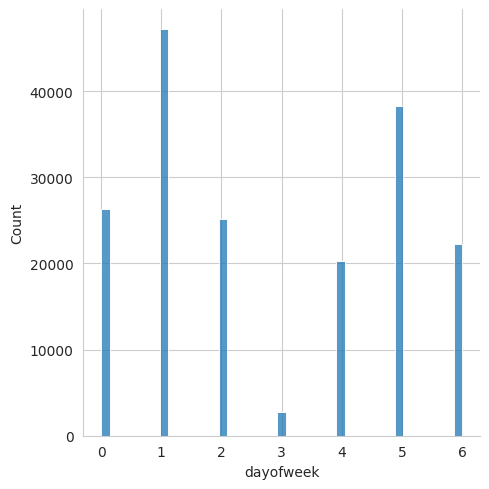

<Figure size 500x200 with 0 Axes>

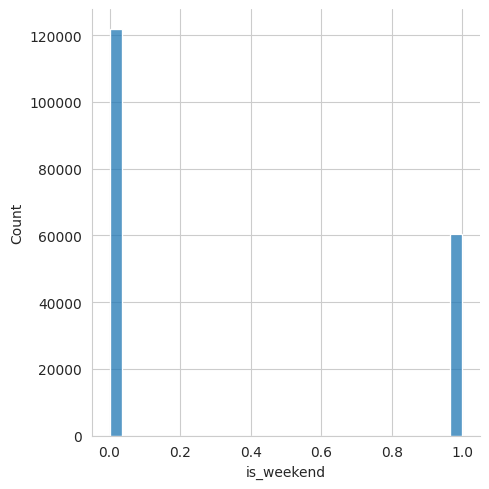

In [110]:
for col in num_values.columns:
    plt.figure(figsize=(5, 2))
    sns.displot(num_values[col])

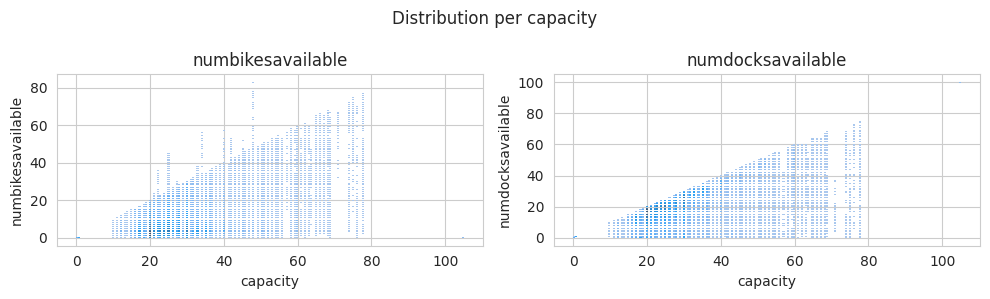

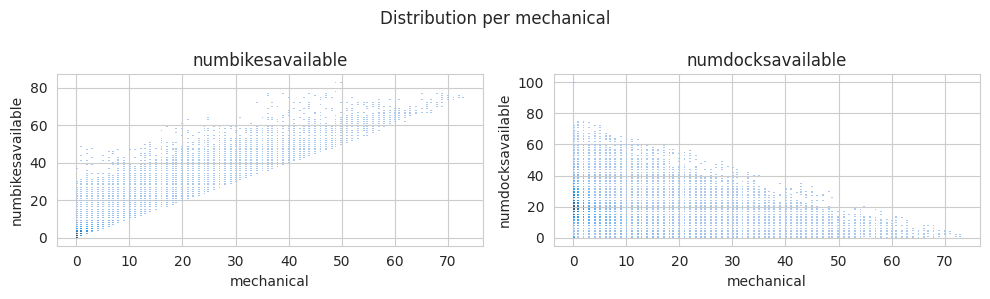

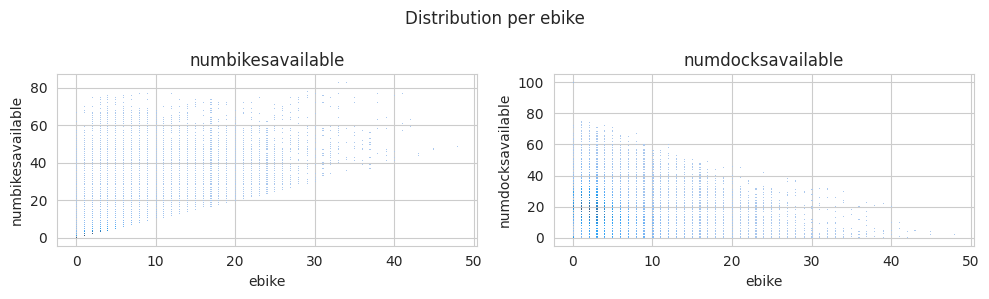

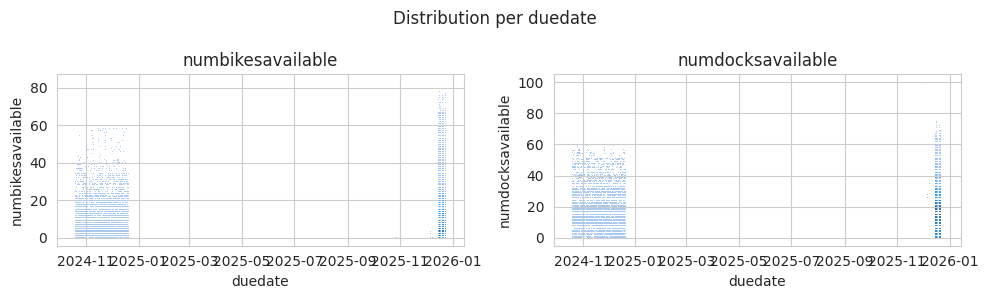

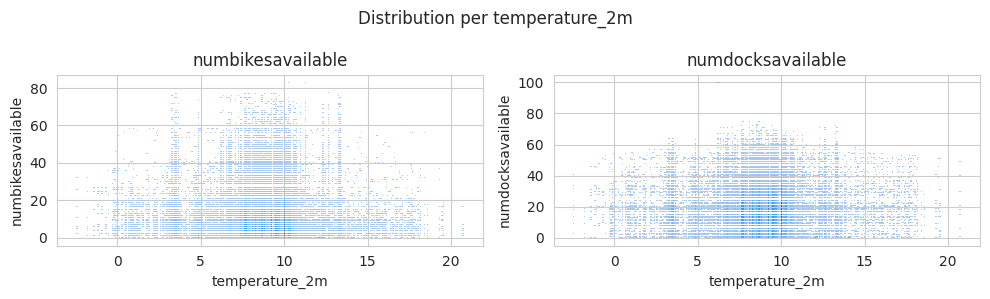

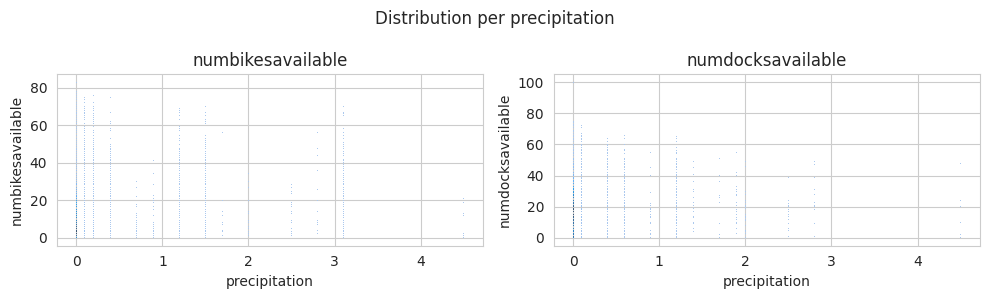

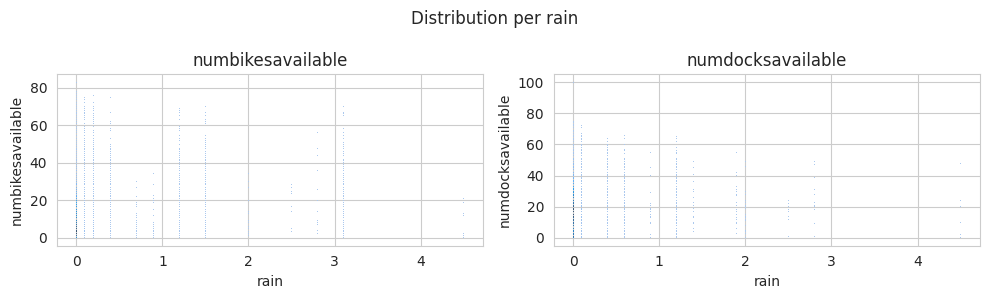

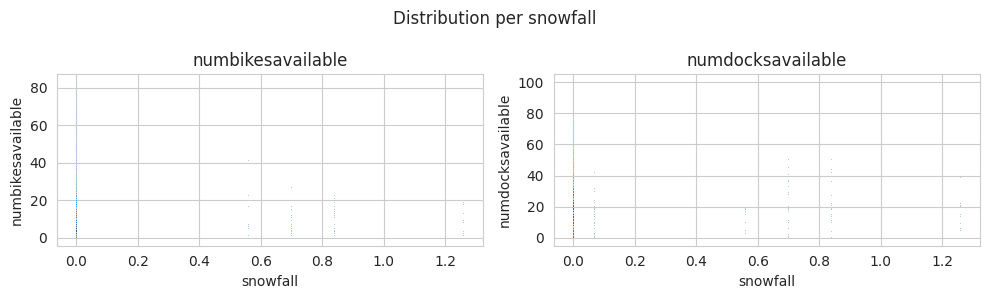

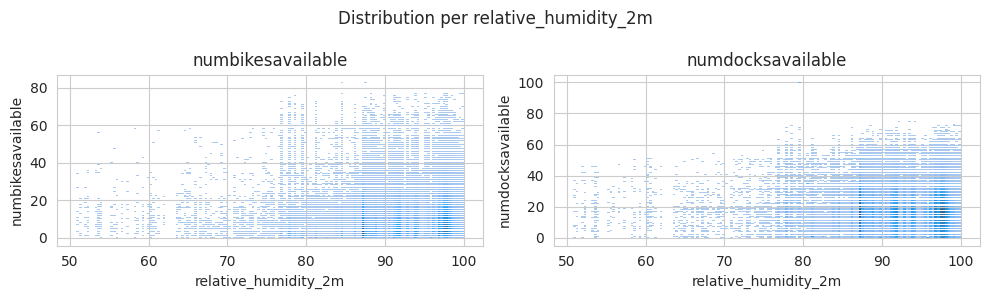

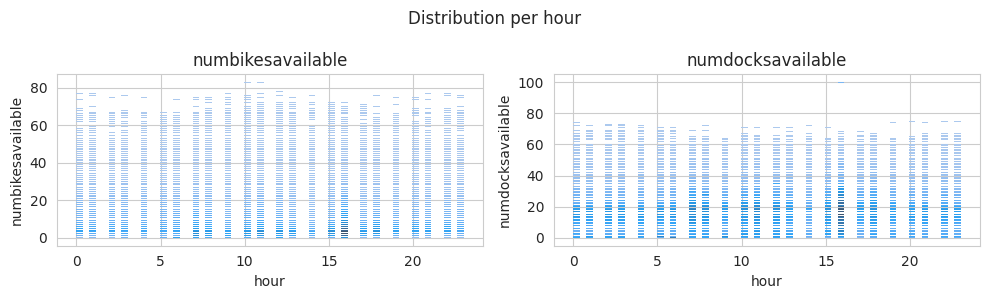

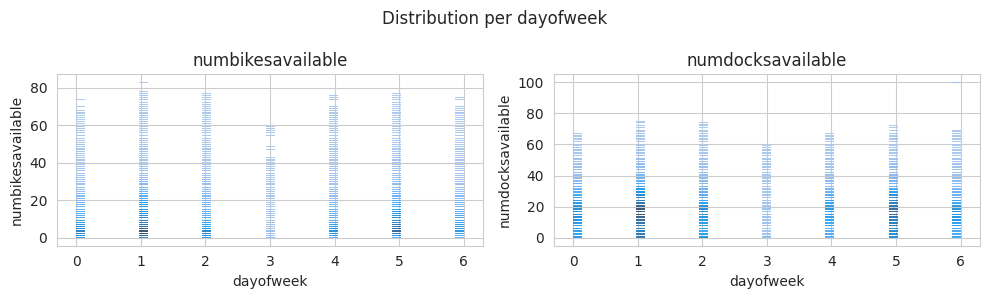

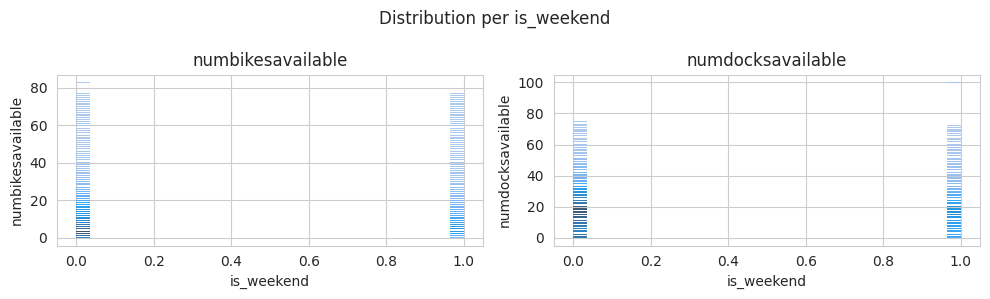

In [111]:
num_values.drop(columns=targets.columns, inplace=True)

for col in num_values.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=False)

    sns.histplot(
        x=num_values[col],
        y=targets['numbikesavailable'],
        ax=axes[0]
    )
    axes[0].set_title("numbikesavailable")

    sns.histplot(
        x=num_values[col],
        y=targets['numdocksavailable'],
        ax=axes[1]
    )
    axes[1].set_title("numdocksavailable")

    fig.suptitle(f"Distribution per {col}")
    plt.tight_layout()


In [112]:
df.to_parquet('../data/cleaned_data.parquet')